In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq import odeint
from tqdm import tqdm

In [11]:
from dataclasses import dataclass

@dataclass
class Dataset:
    y: torch.tensor
    t: torch.tensor

    @staticmethod
    def get_batch(true_y, t, batch_size, batch_time):
        s = torch.from_numpy(np.random.choice(np.arange(len(t) - batch_time, dtype=np.int64), batch_size, replace=False))
        batch_y0 = true_y[s]  # (M, D)
        batch_t = t[:batch_time]  # (T)
        batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
        return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


Batching was introduced to randomly select y_true values as starting y0 vectors and then to select the next batch_time timesteps and return batch_y i.e. the true values of the equations starting with vector batch_y0[n] and integrating between 0-t[i] where i = batch_time.

Lorentz equations:

In [66]:
#  From https://scipython.com/blog/the-lorenz-attractor/
# Lorenz parameters and initial conditions.
sigma, beta, rho = 10, 2.667, 28
#sigma, beta, rho = 10, 8/3, 15
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE

class Lambda(nn.Module):
    def forward(self, t, y):
        """The Lorenz equations."""
        u, v, w = y[0]
        up = -sigma*(u - v)
        vp = rho*u - v - u*w
        wp = -beta*w + u*v
        return torch.tensor([[up, vp, wp]]).to(device)

Obtain true values from numerical DE solver:

In [67]:
t = torch.linspace(0., 25., 5000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values

dataset = Dataset(y=true_y, t=t)

Define Neural ODE:

In [68]:
class ODENN(nn.Module):

    def __init__(self, layers):
        super(ODENN, self).__init__()

        self.layers = layers

        for m in self.layers.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.layers(y)
    
    def trainmodel(self, dataset, optimizer, epochs, train_ratio=1):
        validation = False if train_ratio == 1 else True
        train_losses, validation_losses, iterations = [],[],[]
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            iterations.append(epoch)
            true_y = dataset.y
            t = dataset.t
            train_y = true_y[:int(len(true_y)*train_ratio)]
            train_t = t[:int(len(t)*train_ratio)]
            validation_y = true_y[int(len(true_y)*train_ratio):]
            validation_t = t[int(len(t)*train_ratio):]

            batch_y0, batch_t, batch_ytrue = Dataset.get_batch(train_y, train_t, batch_size=100, batch_time=100)
            pred_y = odeint(self, batch_y0, batch_t).to(device)


            loss = torch.mean(torch.abs(pred_y - batch_ytrue))
            loss.backward()
            optimizer.step()
            train_losses.append(float(loss))
            if validation:
                batch_y0, batch_t, batch_ytrue = Dataset.get_batch(validation_y, validation_t, batch_size=50, batch_time=50)
                pred_y = self.predict(batch_y0, batch_t)
                loss = torch.mean(torch.abs(pred_y - batch_ytrue))
                validation_losses.append(float(loss))

        plt.plot(iterations, train_losses, label='training loss')
        if validation:
            plt.plot(iterations, validation_losses, label='validation loss')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.legend()
        plt.show()
        print(f"Final training loss: {train_losses[-1]}")
    
    def predict(self, y0, t):
        with torch.no_grad():
            pred_y = odeint(self, y0, t).to(device)
        return pred_y
        

        

train loop:

100%|██████████| 1000/1000 [06:28<00:00,  2.58it/s]


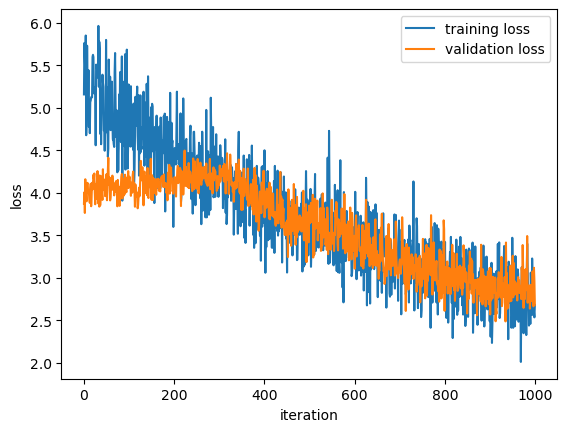

Final training loss: 2.6821892261505127


In [69]:
net=ODENN(nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 3),
        )).to(device)
        
optimizer = optim.RMSprop(net.parameters(), lr=1e-3)
net.trainmodel(dataset, optimizer, epochs=1000, train_ratio=0.9)

Plotting:

In [14]:
def plot_trajectory(pred_y, true_y, t):
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(121, frameon=False)
    ax_phase = fig.add_subplot(122, projection='3d')

    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y,z')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,0], 'k-', label='true x')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,1], 'm-', label='true y')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,2], 'b-', label='true z')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,0], 'k--', label='predicted x')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,1], 'm--', label='predicted y')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,2], 'b--', label='predicted z')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    #ax_traj.set_ylim(-2, 2)
    ax_traj.legend()

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.plot(true_y.cpu().numpy()[:,:,0], true_y.cpu().numpy()[:,:,1], true_y.cpu().numpy()[:,:,2], 'g--', label="True")

    s=10
    n=len(t)
    line_segments = [(pred_y.cpu().numpy()[:,:,0][i:i+s+1], pred_y.cpu().numpy()[:,:,1][i:i+s+1], pred_y.cpu().numpy()[:,:,2][i:i+s+1]) for i in range(0,n-s,s)]
    segment_colours = [plt.cm.winter(i/n) for i in range(0,n-s,s)]
    #lines = Line3DCollection(line_segments, colors = segment_colours, label='Predicted')
    #ax_phase.add_collection(lines)
    for i, line in enumerate(line_segments):
        ax_phase.plot(line[0], line[1], line[2], color = segment_colours[i])

    #ax_phase.plot(pred_x, pred_y, pred_z, 'b--')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.set_zlabel('z')
    ax_phase.legend()
    plt.show()

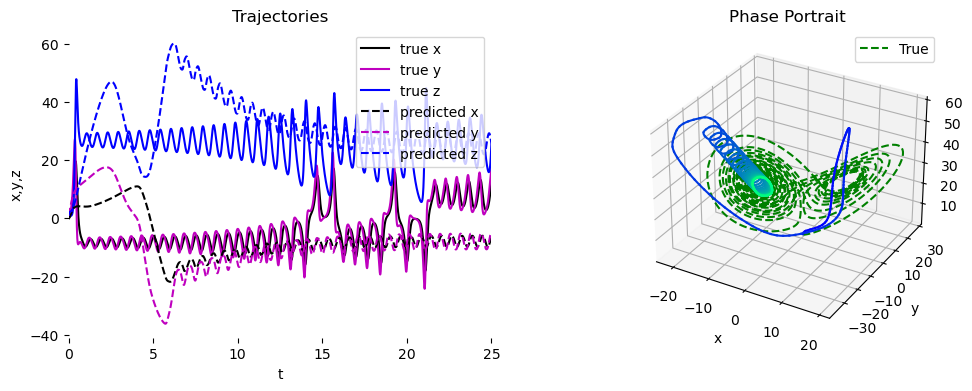

In [70]:
pred_y = net.predict(true_y[0], t)
plot_trajectory(pred_y, true_y, t)

It can be seen that that all predicted x,y,z trajectories seem to follow the overall shape of the true trajectories but lack the higher frequency oscillations, as if a rolling average had been taken. This seems to make sense given that the loss is defined as the average of the difference between the true and predicted trajectories. Thus, by further decreasing the loss the model should be able to predict these higher frequency oscillations. To do this a more complex model will be trained.

Experiment with models:

100%|██████████| 500/500 [10:00<00:00,  1.20s/it]


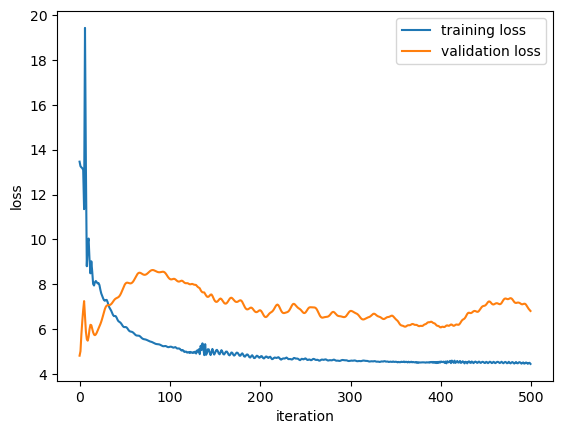

Final training loss: 4.444281101226807


In [15]:
net2=ODENN(nn.Sequential(
            nn.Linear(3, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 3),
        )).to(device)
        
optimizer = optim.RMSprop(net2.parameters(), lr=0.0001)
net2.trainmodel(true_y, t, optimizer, epochs=500, train_ratio=0.9)

100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


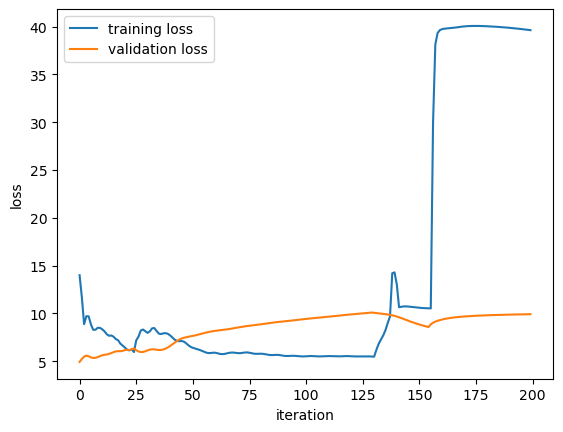

Final training loss: 39.62372970581055


In [16]:
net3=ODENN(nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3),
        )).to(device)
        
optimizer = optim.RMSprop(net3.parameters(), lr=0.0001)
net3.trainmodel(true_y, t, optimizer, epochs=200, train_ratio=0.9)

100%|██████████| 200/200 [05:14<00:00,  1.57s/it]


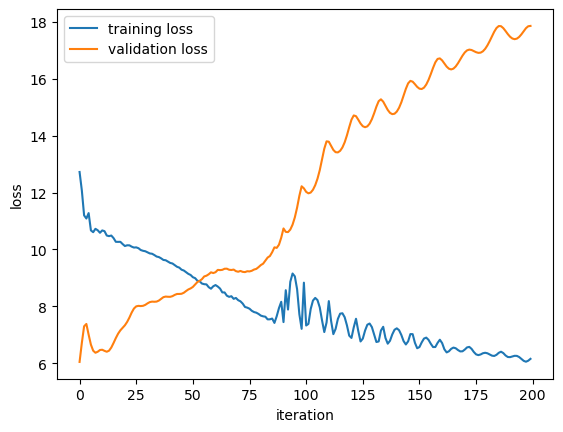

Final training loss: 6.157114505767822


In [17]:
net4=ODENN(nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
        )).to(device)
        
optimizer = optim.RMSprop(net4.parameters(), lr=0.0001)
net4.trainmodel(true_y, t, optimizer, epochs=200, train_ratio=0.9)

100%|██████████| 200/200 [02:38<00:00,  1.26it/s]


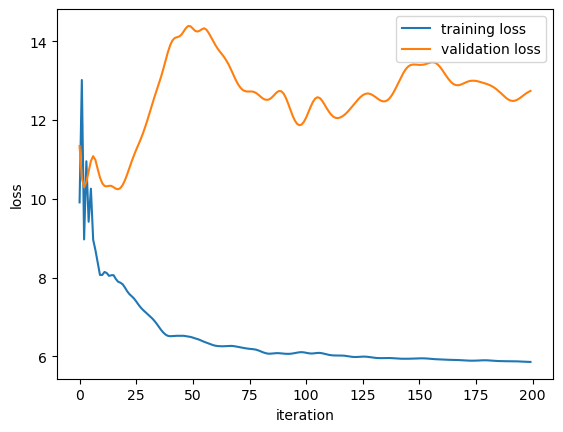

Final training loss: 5.855517387390137


In [18]:
t = torch.linspace(0., 50., 2000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values

net=ODENN(nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3),
        )).to(device)
        
optimizer = optim.RMSprop(net.parameters(), lr=0.0001)
net.trainmodel(true_y, t, optimizer, epochs=200, train_ratio=0.9)

This paper: https://arxiv.org/pdf/1910.07291.pdf talks about using "ensemble solutions, i.e. creating datasets comprising of various simulations starting from different initial conditions.

In [ ]:
# create datasets

n_datasets = 20

datasets = []
for i in range(n_datasets):
    
with torch.no_grad():
    t = torch.linspace(0., 25., 1000).to(device) # time over which ODE is integrated
    y0 = torch.tensor([[np.random.uniform(0,3) for j in range 3]]).to(device) # create a random y0 vector arbitrarily constrained between 0-3.
    y = odeint(Lambda(), y0, t, method='dopri5') # calculate true_y values
    datasets.append({'true_y': y, 't': t})
